# Setup

In [8]:
import gc
import random

import astropy.units as u
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sunpy.map
import sunpy.visualization.colormaps.color_tables as ct
from astropy.visualization import AsinhStretch, ImageNormalize
from IPython.display import clear_output, display
from matplotlib.patches import Rectangle
from sunpy.coordinates import frames
from tqdm import tqdm
import json
import random
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

from contextlib import contextmanager

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *
from Library.CH import *
from Library.Plot import *

# CH Stats

In [11]:
# import sys, subprocess

# subprocess.run(
#     [sys.executable, "-m", "Scripts.Make", "Stats", "A1", "D1", "P1"],
#     check=True,
# )


In [12]:
df_p = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")
print(f"Loaded {len(df_p)} paths from Paths.parquet")


Loaded 20166 paths from Paths.parquet


In [1]:
from Models import load_date_range

# Add/remove specs here
specs = ["A2D2", "A2D1"]
postprocessing = "P1"


def parse_spec(spec):
    spec = spec.strip()
    if len(spec) < 4:
        raise ValueError(f"Invalid spec: {spec}")
    arch_id = spec[:2]
    date_id = spec[2:]
    return arch_id, date_id


def find_stats_path(arch_id, date_id, postprocessing):
    root = Path("./Outputs") / "Stats"
    candidates = [
        root / f"{arch_id}{date_id}{postprocessing} Stats.parquet",
        root / f"{arch_id}{date_id}{postprocessing}_stats.parquet",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"No stats parquet found for {arch_id}{date_id}{postprocessing} in {root}"
    )


def prepare_stats_df(df):
    df = df.copy()
    df.index.name = "key"

    dt_index = pd.to_datetime(df.index.str[:13], format="%Y%m%d_%H%M", errors="coerce")
    df = df[~dt_index.isna()].copy()
    df["time"] = dt_index[~dt_index.isna()]
    df = df.sort_values("time")

    stats_df = df.filter(like="oval")
    stats_df.index = df["time"]
    stats_df.columns = stats_df.columns.str.replace("_oval", "", regex=False)

    stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
    stats_df.index = pd.to_datetime(stats_df.index, format="%Y%m%d_%H%M")
    stats_df = stats_df.resample("1d").median()
    return df, stats_df


stats_data = {}
for spec in specs:
    arch_id, date_id = parse_spec(spec)
    stats_path = find_stats_path(arch_id, date_id, postprocessing)
    df = pd.read_parquet(stats_path)
    df, stats_df = prepare_stats_df(df)

    date_range = load_date_range(arch_id, date_id)
    train_df, _ = date_range.select_pairs(df_p)

    stats_data[spec] = {
        "df": df,
        "stats_df": stats_df,
        "train_df": train_df,
        "path": stats_path,
    }

list(stats_data.keys())


NameError: name 'Path' is not defined

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_3136/4258260899.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


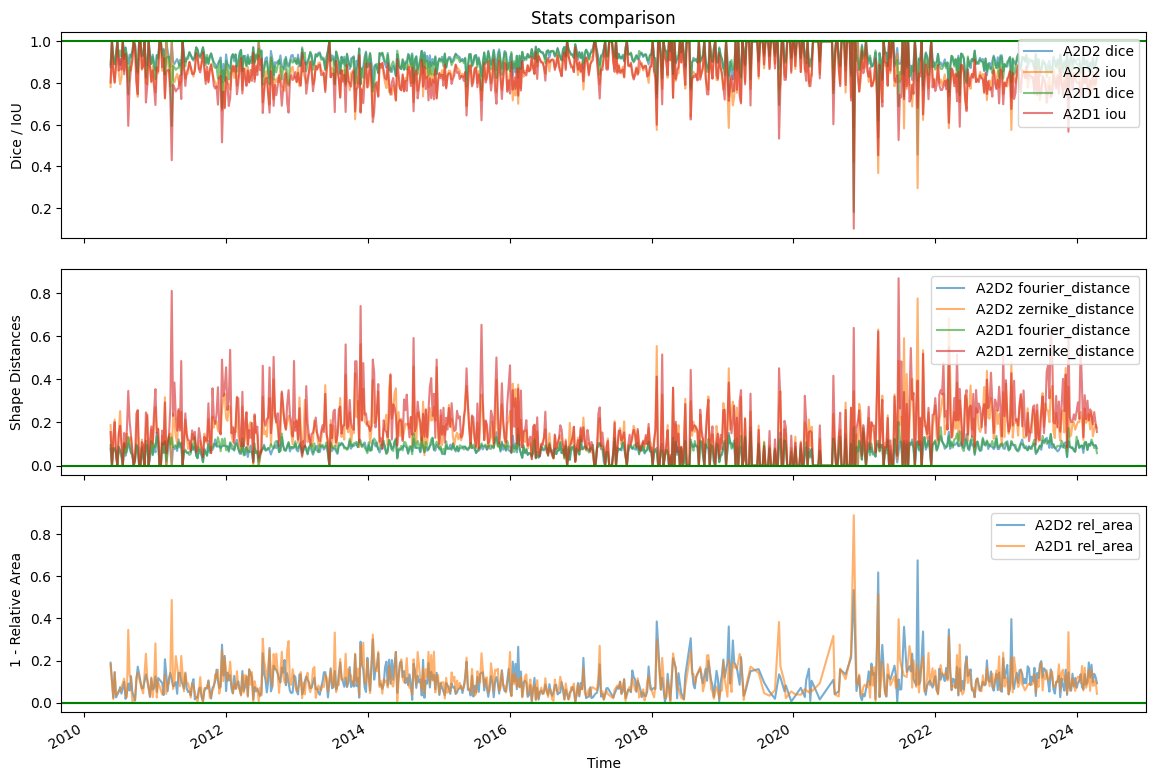

In [14]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True, gridspec_kw={"hspace": 0.15}
)

# make A1 dashed for quick visual separation
styles = {}
for spec in stats_data.keys():
    styles[spec] = {"linestyle": "--", "alpha": 0.6} if spec.startswith("A1") else {"linestyle": "-", "alpha": 0.6}

# ====================================================
# AXIS 1 — Dice / IoU (remove zeros)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})

    if "dice" in stats_df:
        dice_clean = stats_df["dice"].replace([0], pd.NA).dropna()
        ax1.plot(
            dice_clean.index,
            dice_clean,
            label=f"{label} dice",
            linestyle=style["linestyle"],
            alpha=style["alpha"],
        )

    if "iou" in stats_df:
        iou_clean = stats_df["iou"].replace([0], pd.NA).dropna()
        ax1.plot(
            iou_clean.index,
            iou_clean,
            label=f"{label} iou",
            linestyle=style["linestyle"],
            alpha=style["alpha"],
        )

ax1.axhline(1, color="green")
ax1.set_ylabel("Dice / IoU")
ax1.legend(loc="upper right")
ax1.set_title("Stats comparison")

# ====================================================
# AXIS 2 — Fourier / Zernike distances (remove ones)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})

    if "fourier_distance" in stats_df:
        fd_clean = stats_df["fourier_distance"].replace([1], pd.NA).dropna()
        ax2.plot(
            fd_clean.index,
            fd_clean,
            label=f"{label} fourier_distance",
            linestyle=style["linestyle"],
            alpha=style["alpha"],
        )

    if "zernike_distance" in stats_df:
        zd_clean = stats_df["zernike_distance"].replace([1], pd.NA).dropna()
        ax2.plot(
            zd_clean.index,
            zd_clean,
            label=f"{label} zernike_distance",
            linestyle=style["linestyle"],
            alpha=style["alpha"],
        )

ax2.axhline(0, color="green")
ax2.set_ylabel("Shape Distances")
ax2.legend(loc="upper right")

# ====================================================
# AXIS 3 — rel_area (remove NaN and zeros)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})

    if "rel_area" in stats_df:
        rel = np.abs(stats_df["rel_area"].replace([0], pd.NA).dropna())
        ax3.plot(
            rel.index,
            rel,
            label=f"{label} rel_area",
            linestyle=style["linestyle"],
            alpha=style["alpha"],
        )
        ax3.axhline(0, color="green")

ax3.set_ylabel("1 - Relative Area")
ax3.set_xlabel("Time")
ax3.legend(loc="upper right")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [17]:
metrics = ["fourier_distance", "zernike_distance", "rel_area", "iou", "dice"]

rows = []
for dr in ["D1", "D2"]:
    # collect all specs that end with this date range
    dfs = []
    for spec, data in stats_data.items():
        if spec.endswith(dr):
            df = data["stats_df"][metrics].copy()
            dfs.append(df)

    if not dfs:
        rows.append(pd.Series([np.nan]*len(metrics), index=metrics, name=dr))
        continue

    combined = pd.concat(dfs)
    # aggregate across whole dataset (median is robust)
    rows.append(combined.median().rename(dr))

table = pd.concat(rows, axis=1)
table


,D1,D2
fourier_distance,0.081407,0.077930
zernike_distance,0.164347,0.145256
rel_area,0.076929,0.075076
iou,0.844506,0.850448
dice,0.915698,0.919180


NameError: name 'plot_metric' is not defined

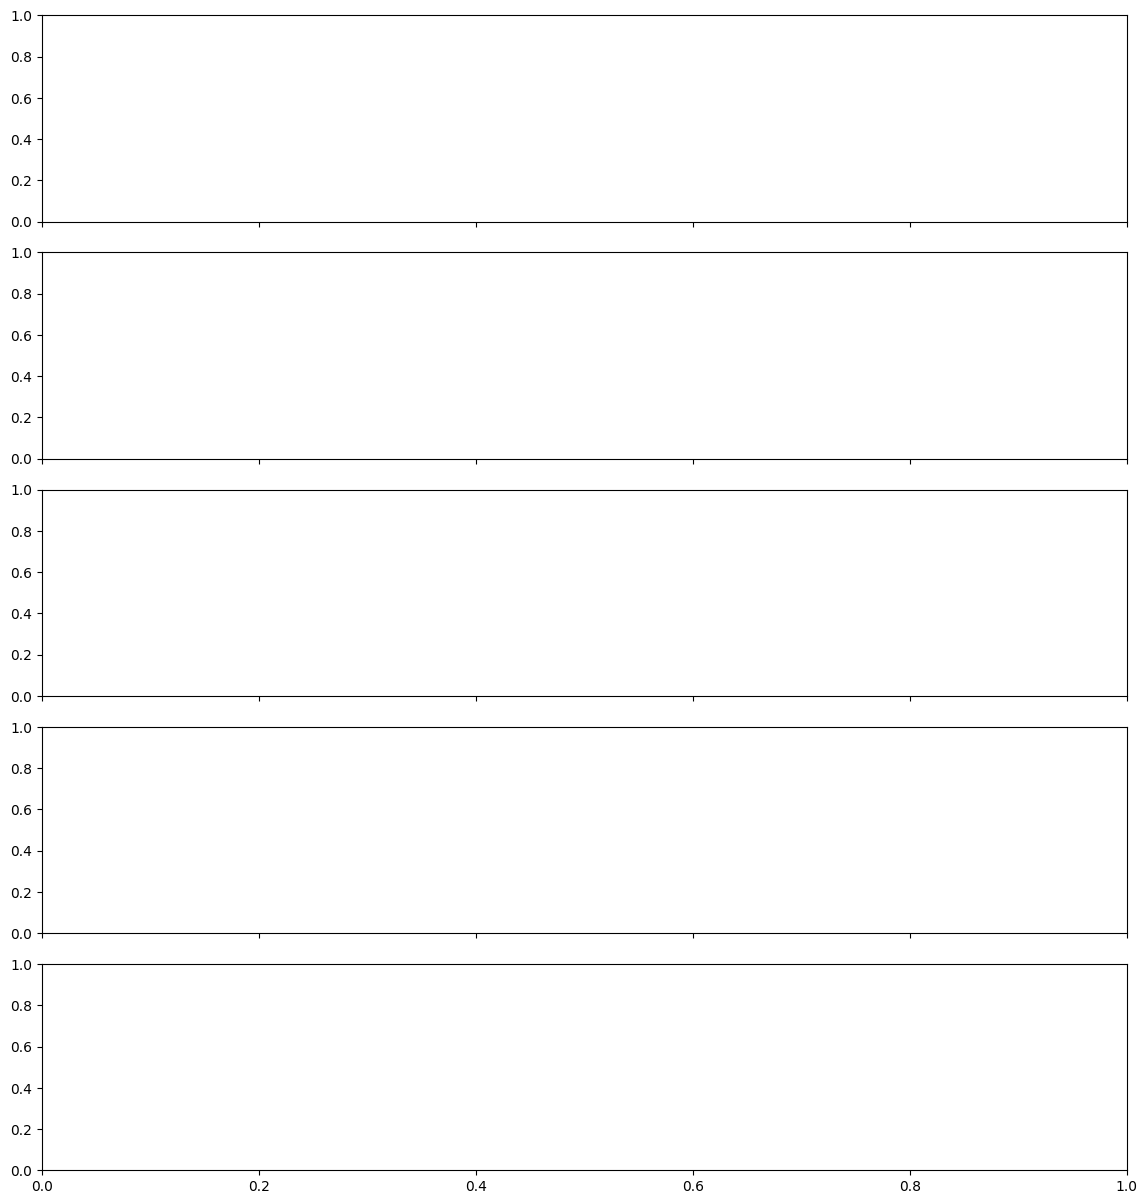

In [14]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    5, 1, figsize=(14, 15), sharex=True, gridspec_kw={"hspace": 0.15}
)

styles = {
    "A1 D1": {"linestyle": "--", "alpha": 0.6},
    "A2 D1": {"linestyle": "-", "alpha": 0.6},
}

metric_specs = [
    ("dice", ax1, 0, False, "Dice"),
    ("iou", ax2, 0, False, "IoU"),
    ("fourier_distance", ax3, 1, False, "Fourier"),
    ("zernike_distance", ax4, 1, False, "Zernike"),
    ("rel_area", ax5, 0, True, "rel_area"),
]

for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})
    for metric, ax, drop_value, abs_value, label_suffix in metric_specs:
        plot_metric(
            ax,
            stats_df,
            metric,
            label,
            style,
            drop_value=drop_value,
            abs_value=abs_value,
            label_suffix=label_suffix,
        )

ax1.axhline(1, color="green")
ax2.axhline(1, color="green")
ax1.set_ylabel("Dice")
ax2.set_ylabel("IoU")
ax1.legend(loc="upper right")
ax1.set_title("A1 vs A2 stats")

ax3.axhline(0, color="green")
ax4.axhline(0, color="green")
ax3.set_ylabel("Fourier")
ax4.set_ylabel("Zernike")
ax3.legend(loc="upper right")

ax5.axhline(0, color="green")
ax5.set_ylabel("1 - Relative Area")
ax5.set_xlabel("Time")
ax5.legend(loc="upper right")

df_for_mask = df2
times = df_for_mask["time"].to_numpy()
a1_spans = spans_from_mask(times, make_train_mask(df_for_mask, a1d1["train_df"]))
a2_spans = spans_from_mask(times, make_train_mask(df_for_mask, a2d1["train_df"]))

for ax in (ax1, ax2, ax3, ax4, ax5):
    add_spans(ax, a1_spans, color="blue", alpha=0.1, zorder=-1)
    add_spans(ax, a2_spans, color="orange", alpha=0.1, zorder=-2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# Luminance Analysis

In [48]:
def init_stats():
    return {"n": 0, "mean": 0.0, "M2": 0.0, "min": np.inf, "max": -np.inf, "skipped": 0}


In [49]:
def update_stats(stats, arr):
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return
    stats["min"] = min(stats["min"], float(arr.min()))
    stats["max"] = max(stats["max"], float(arr.max()))

    n = stats["n"]
    mean = stats["mean"]
    M2 = stats["M2"]

    batch_n = arr.size
    batch_mean = float(arr.mean())
    batch_M2 = float(arr.var(ddof=0) * batch_n)

    if n == 0:
        stats["n"] = batch_n
        stats["mean"] = batch_mean
        stats["M2"] = batch_M2
        return

    delta = batch_mean - mean
    total_n = n + batch_n
    stats["mean"] = mean + delta * batch_n / total_n
    stats["M2"] = M2 + batch_M2 + (delta * delta) * n * batch_n / total_n
    stats["n"] = total_n


In [50]:
from collections import defaultdict
stats_by_year = defaultdict(init_stats)


In [51]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    year = str(idx)[:4]  # index like YYYYMMDD_HHMM
    try:
        _, img = prepare_fits(row.fits_path)
    except Exception:
        stats_by_year[year]["skipped"] += 1
        continue
    update_stats(stats_by_year[year], img)

100%|██████████| 20166/20166 [00:00<00:00, 69250.20it/s]


In [52]:
rows = []
for year, s in sorted(stats_by_year.items()):
    std = float(np.sqrt(s["M2"] / s["n"])) if s["n"] else float("nan")
    rows.append(
        {
            "year": year,
            "n": s["n"],
            "skipped": s["skipped"],
            "min": s["min"],
            "max": s["max"],
            "mean": s["mean"],
            "std": std,
        }
    )

yearly_stats = pd.DataFrame(rows)

In [53]:
rows.to_parquet("./Outputs/Stats/Luminance.parquet")
yearly_stats

AttributeError: 'list' object has no attribute 'to_parquet'

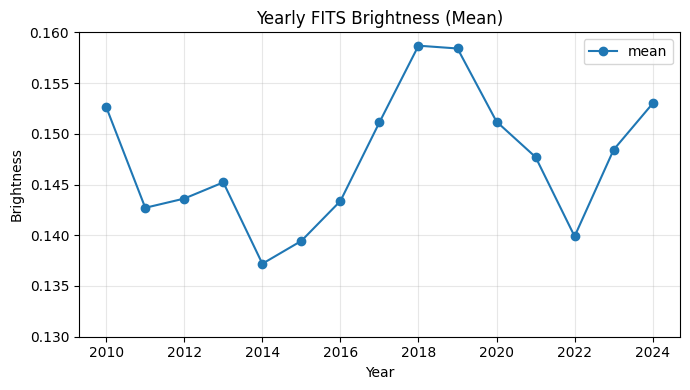

In [ ]:
import matplotlib.pyplot as plt

# Ensure year is sorted and numeric-ish for plotting
plot_df = yearly_stats.copy()
plot_df["year"] = plot_df["year"].astype(int)
plot_df = plot_df.sort_values("year")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(plot_df["year"], plot_df["mean"], marker="o", label="mean")

# ax.fill_between(
#     plot_df["year"],
#     plot_df["mean"] - plot_df["std"],
#     plot_df["mean"] + plot_df["std"],
#     alpha=0.2,
#     label="±1 std",
# )

ax.set_xlabel("Year")
ax.set_ylabel("Brightness")
ax.set_title("Yearly FITS Brightness (Mean)")
ax.grid(True, alpha=0.3)
ax.set_ylim(0.13, 0.16)
ax.legend()
plt.tight_layout()
plt.show()
